# predict philly property price

The goal of this project is to predict the value of homes in Philadelphia and identify features that drive up home value. 

Property data is sourced from OpenDataPhilly and the City of Philadelphia Office of Property Assessment: https://www.phila.gov/property/data/#

Info features in the dataset were downloaded from this url: https://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/

In addition to the information in the above dataset, additional information on school locations will be used to calculate proximity to schools: https://www.opendataphilly.org/dataset/schools/resource/8e1bb3e6-7fb5-4018-95f8-63b3fc420557

## Evaluate the LGBMRegressor model

In [1]:
import geopandas
import pandas as pd
import numpy as np
import os
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = [5.0, 4.0]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

Look at feature importances again, now after using all data:

In [3]:
import lightgbm as lightgbm
modeldir = 'models'
with open(os.path.join(modeldir,'fullmdl'),"rb") as f:
    mdl = pickle.load(f)
f.close()

In [4]:
interimdatadir = 'interim_data'
df = pd.read_pickle(os.path.join(interimdatadir,'df_cleaned'))
target = 'market_value'
target_y = df[target]
features = df.columns
features = features.drop(target)

impfeat = pd.DataFrame({'features':features,'importance':list(mdl.feature_importances_)})
impfeat = impfeat.sort_values('importance',ascending=False)

<Figure size 7500x30000 with 0 Axes>

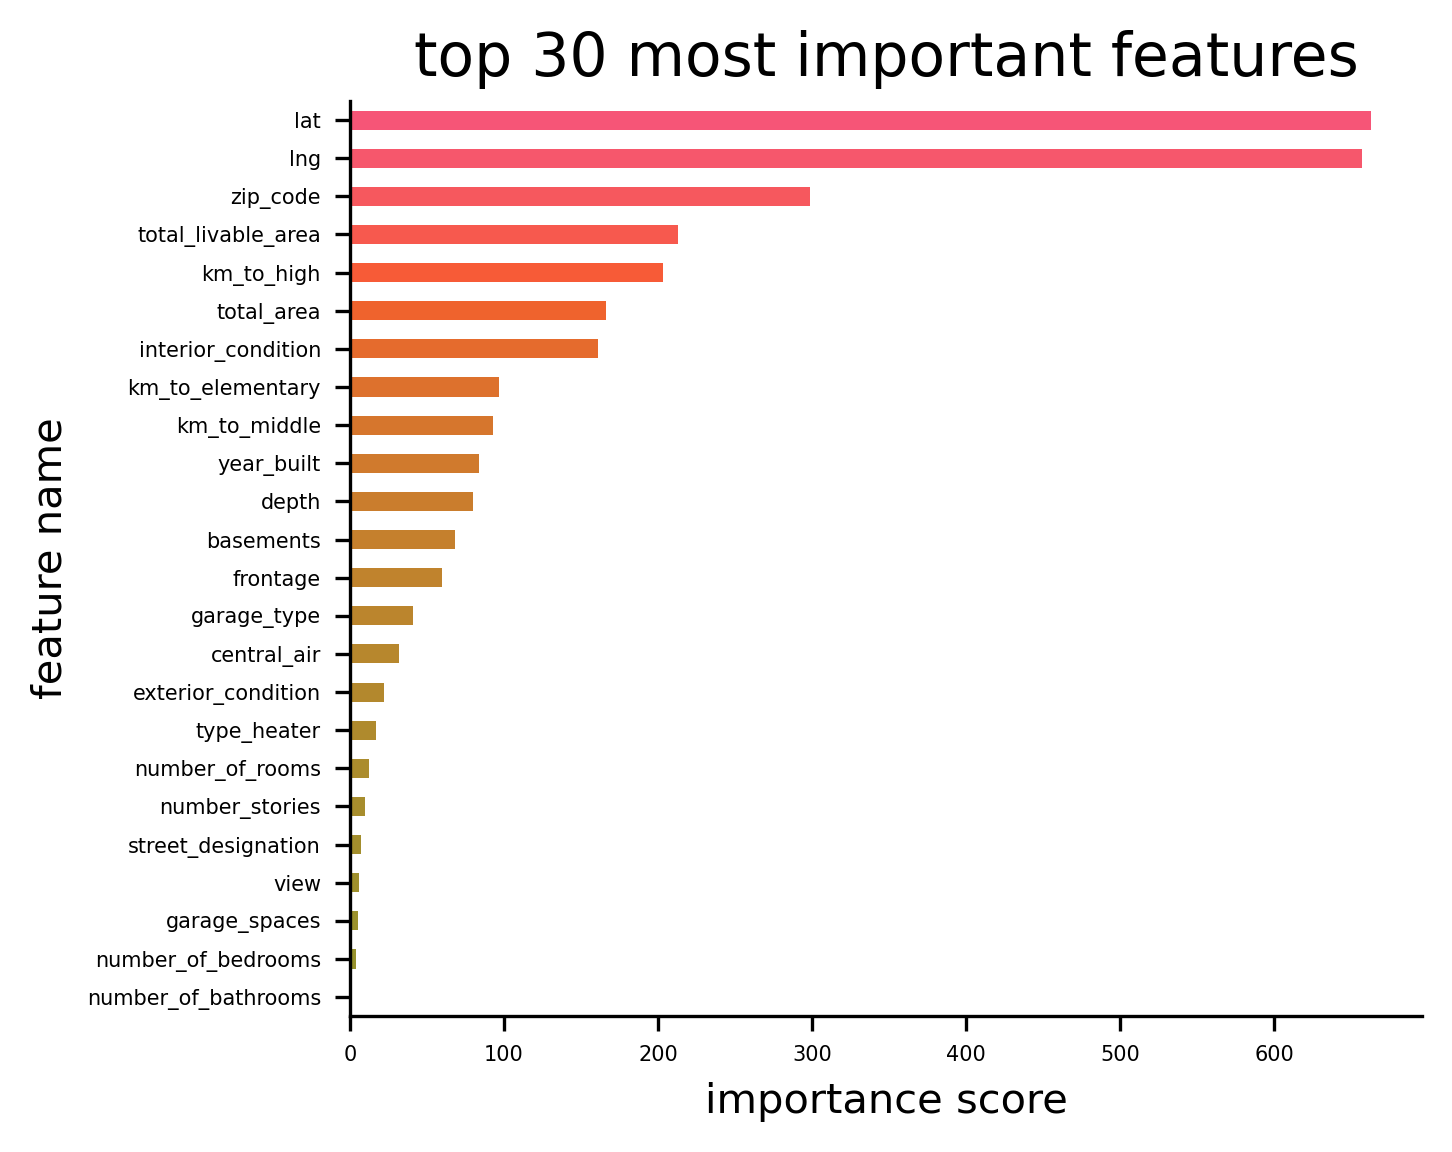

In [5]:
fig = plt.figure(figsize=(25,100))
colors = sns.husl_palette(n_colors=int(100), h=0.01, s=0.9, l=0.6, as_cmap=False)
impfeat[:30].plot(x='features',y='importance',kind='barh',color=colors,fontsize=5)
plt.xlabel('importance score',fontsize=10)
plt.ylabel('feature name',fontsize=10)
sns.despine()
plt.title('top 30 most important features')
ax = plt.gca()
ax.invert_yaxis()
ax.get_legend().remove()
plt.tight_layout()
plt.show()

In [11]:
phlmap = geopandas.read_file(os.path.join('Zipcodes_Arc-shp','e623fad0-e103-46bb-bcd9-8e3e7851214c2020329-1-71i91a.o48wc.shp'))
phlmap = phlmap.to_crs("EPSG:3395") 

In [12]:
sub_df = df[['market_value','zip_code','lat','lng']]

In [13]:
phl_df = phlmap.merge(sub_df,left_on='ZIP_LEFT',right_on='zip_code')

In [13]:
phl_df = phlmap.merge(sub_df,left_on='ZIP_LEFT',right_on='zip_code')

In [10]:
#mapplt = phl_df.plot(figsize=(30,20),legend=True,c#oalumn='market_value',cmap='plasma')
mapplt.axis('off')
plt.show()##

NameError: name 'mapplt' is not defined

In [10]:
#mapplt = phl_df.plot(figsize=(30,20),legend=True,c#oalumn='market_value',cmap='plasma')
mapplt.axis('off')
plt.show()##

NameError: name 'mapplt' is not defined

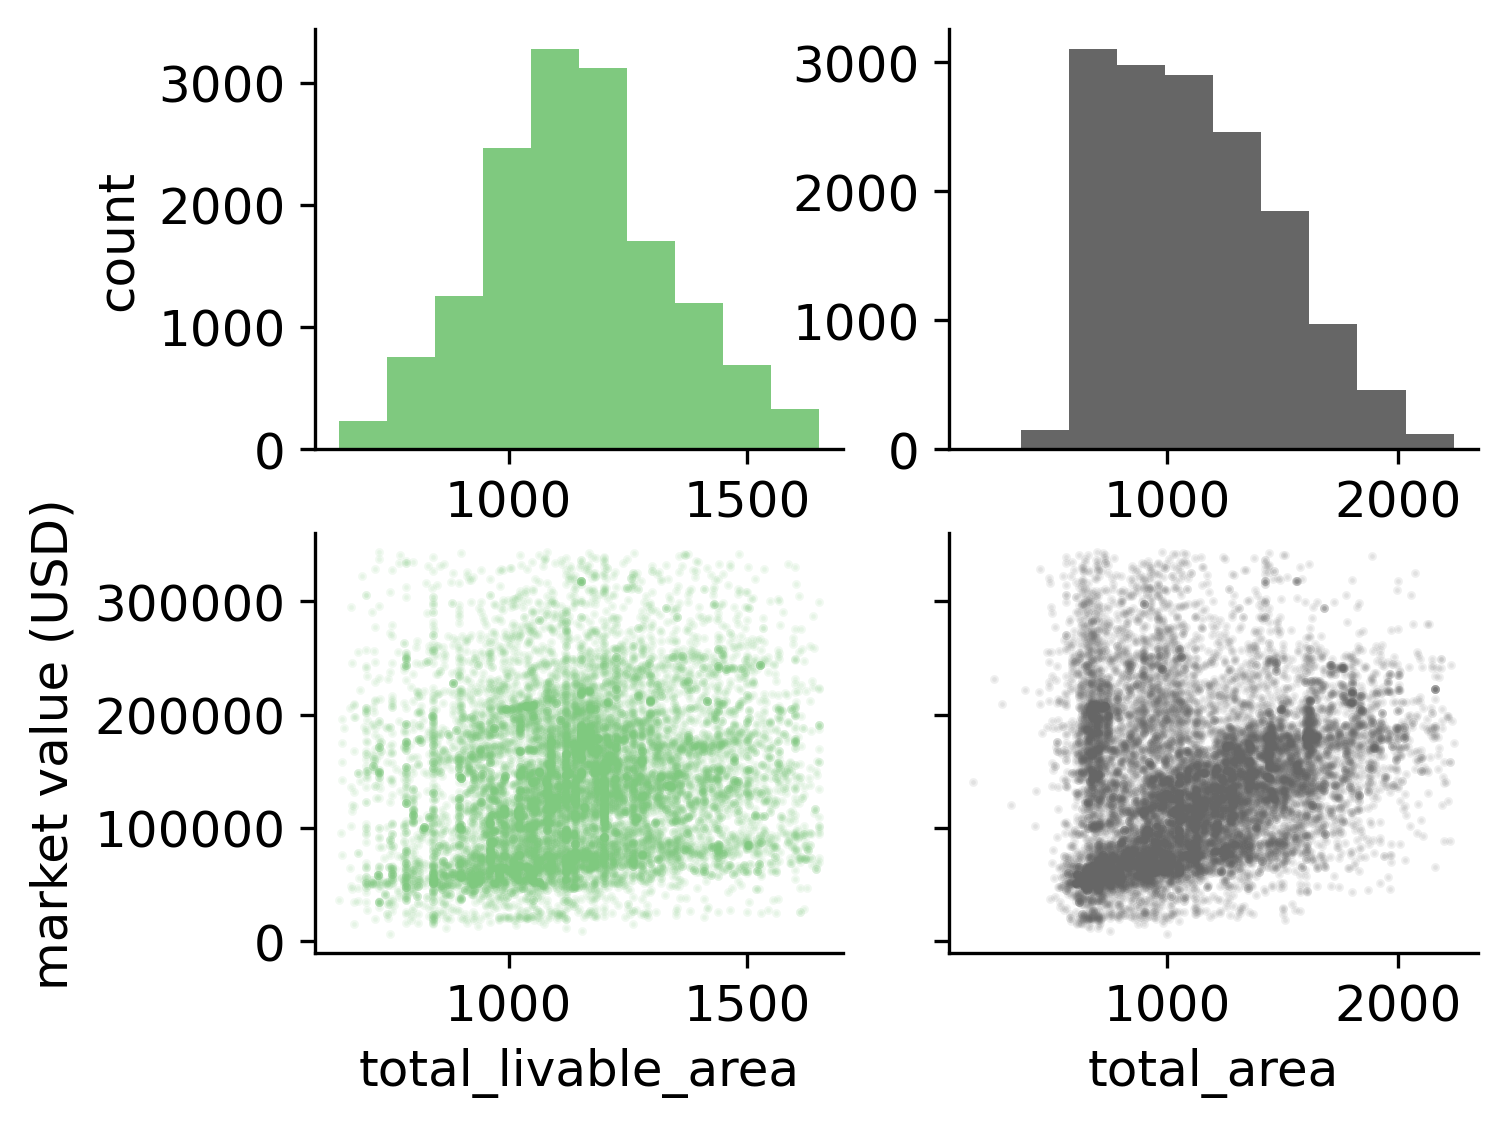

In [10]:
predictors = ['total_livable_area','total_area']
colors = plt.cm.get_cmap('Accent')
its = np.linspace(0,1,num=int(len(predictors)))

fig,ax=plt.subplots(nrows=2,ncols=int(len(predictors)),figsize=(5,4))

cnt =0
for predictor in predictors:
    ax[0,cnt].hist(df[predictor],color=colors(its[cnt]))
    sns.despine()
    ax[0,cnt].ticklabel_format(style='plain')
    ax[0,cnt].set_xlabel(predictor,rotation=0)
    if cnt == 0:
        ax[0,cnt].set_ylabel('count')
    cnt += 1


cnt =0
for predictor in predictors:
    ax[1,cnt].scatter(df[predictor],df[target],s=1.25,alpha=0.1,color=colors(its[cnt]))
    sns.despine()
    ax[1,cnt].ticklabel_format(style='plain')
    ax[1,cnt].set_xlabel(predictor,rotation=0)
    if cnt > 0:
        ax[1,cnt].yaxis.set_ticklabels([])
    if cnt == 0:
        ax[1,cnt].set_ylabel('market value (USD)')
    cnt += 1

plt.show()

Identify instances where the model does poorly:

In [11]:
modeldir = 'models'
interimdatadir = 'interim_data'
mdl = pd.read_pickle(os.path.join(modeldir,'LGBMRegressor'))
X_test = pd.read_pickle(os.path.join(interimdatadir,'X_test.pkl'))
y_test = pd.read_pickle(os.path.join(interimdatadir,'y_test.pkl'))
y_pred = mdl.predict(X_test)

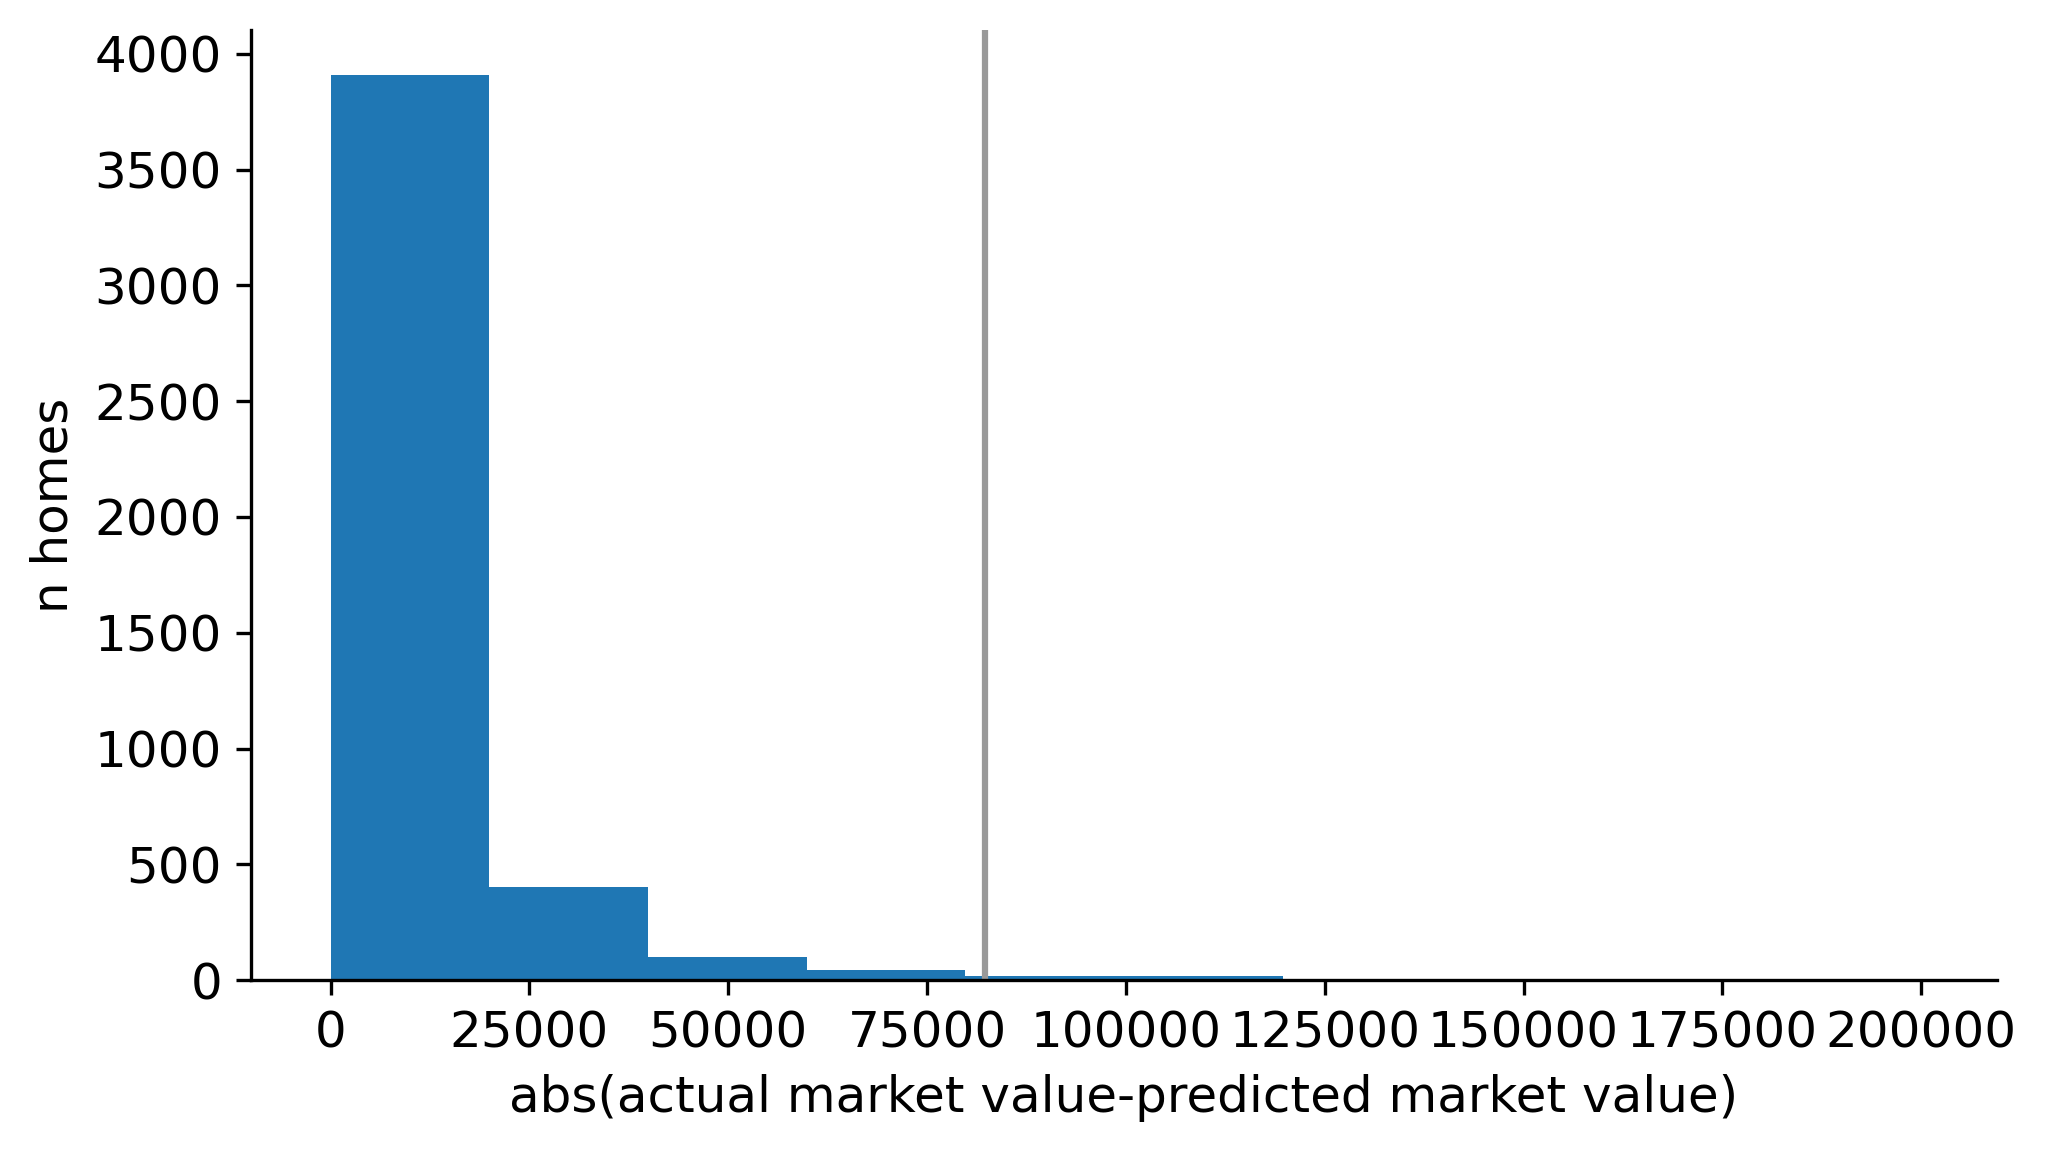

In [12]:
plt.figure(figsize=(7,4))
absdiff = abs(y_test - y_pred)
per99 = np.quantile(absdiff,0.99)
plt.hist(absdiff)
sns.despine()
plt.xlabel('abs(actual market value-predicted market value)')
plt.ylabel('n homes')
plt.axvline(per99,color=[0.6,0.6,0.6])
plt.tight_layout()
plt.show()

In [52]:
pooridx = absdiff > per99